In [3]:
import mido
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import rhythm_regression.midi_processing as mp
import rhythm_regression.unit_conversion as uc
import rhythm_regression.notebook_tools as nbt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Loading MIDI File

In [2]:
mid = mido.MidiFile('./data/midi/CSU_Fight_Song_138bpm.mid')

mid

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='Snare Drum\x00', time=0),
    MetaMessage('time_signature', numerator=2, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='C', time=0),
    MetaMessage('set_tempo', tempo=434783, time=0),
    Message('control_change', channel=9, control=121, value=0, time=0),
    Message('program_change', channel=9, program=56, time=0),
    Message('control_change', channel=9, control=7, value=100, time=0),
    Message('control_change', channel=9, control=10, value=64, time=0),
    Message('control_change', channel=9, control=91, value=0, time=0),
    Message('control_change', channel=9, control=93, value=0, time=0),
    MetaMessage('midi_port', port=0, time=0),
    Message('note_on', channel=9, note=50, velocity=124, time=0),
    Message('note_on', channel=9, note=50, velocity=0, time=239),
    Message('note_on', channel=9, note=50, velocity=96

In [3]:
print(f'Track is {mid.length} seconds')
print(f'{mid.ticks_per_beat} ticks per beat')

Track is 76.08702500000001 seconds
480 ticks per beat


# Tempo Calculation

MIDI stores tempo using microseconds per beat, also known as Pules Per Quarter Note (PPQN), instead of beats per minute (bpm).    The exact conversions are:

$$\text{bpm}=\frac{60 * 1,000,000}{\mu \text{spb}}$$

$$\mu \text{spb}=\frac{60 * 1,000,000}{\text{bpm}}$$


In [1]:
def uspb_to_bpm(uspb):
    return uc.SECONDS_PER_MINUTE * uc.MICROSECONDS_PER_SECOND / uspb

def bpm_to_usbp(bpm):
    return uc.SECONDS_PER_MINUTE * uc.MICROSECONDS_PER_SECOND / bpm

def get_bpm(mid):
    for message in mid.tracks[0]:
        if message.type == 'set_tempo':
            microseconds_per_beat = message.tempo
            bpm = uspb_to_bpm(microseconds_per_beat)
            return bpm

In [4]:
bpm_to_usbp(138)

434782.60869565216

In [5]:
get_bpm(mid)

137.99987580011177

MIDI stores an integer $\mu \text{spb}$ in 3 bytes [[source]](http://midi.teragonaudio.com/tech/midifile/ppqn.htm).  This means that the minimum $\mu \text{spb}$ is 1 and the maximum $\mu \text{spb}$ is $2^{24} - 1$.  This translates to a maximum tempo of 60,000,000 bpm and a minimum tempo of 3.576 bpm.

# MIDI Conversion Rounding Error

MIDI only stores an integer $\mu\text{spb}$, instead of a floating point $\mu\text{spb}$, so when converting back, there can be some rounding error.  How many tempos suffer from this rounding error? How large are these errors?  Do these errors make a noticable / problematic difference over time?

## How many tempos have rounding error?

Let's decide on a maximum tempo to consider.  We will then only consider integer tempos below this, since tempos are almost always given in integer beats per minute.

In [6]:
max_tempo = 400

midi_conversion_errors = pd.DataFrame()
midi_conversion_errors['bpm'] = list(range(1, max_tempo+1))
midi_conversion_errors['uspb'] = 60000000 / midi_conversion_errors['bpm']
midi_conversion_errors['rounded uspb'] = midi_conversion_errors['uspb'].round()
midi_conversion_errors['converted_tempo'] = 60000000 / midi_conversion_errors['rounded uspb']
midi_conversion_errors['error'] = midi_conversion_errors['converted_tempo'] - midi_conversion_errors['bpm']

#midi_conversion_errors.style.hide_index()

In [7]:
proportion_with_error = sum(midi_conversion_errors['error'] != 0) / max_tempo
proportion_with_error

0.9

Unfortunately, it looks like 90% of tempos have this rounding error after conversion to and from MIDI.  This might not be an issue if the errors are small enough.  Let's investigate further.

## How large are the errors?

Let's make a plot of the size of the error (the absolute value) versus tempo.  This can let us know if errors are approximately constant or if the increase with respect to their tempo.

Text(0, 0.5, 'Absolute Error (in BPM)')

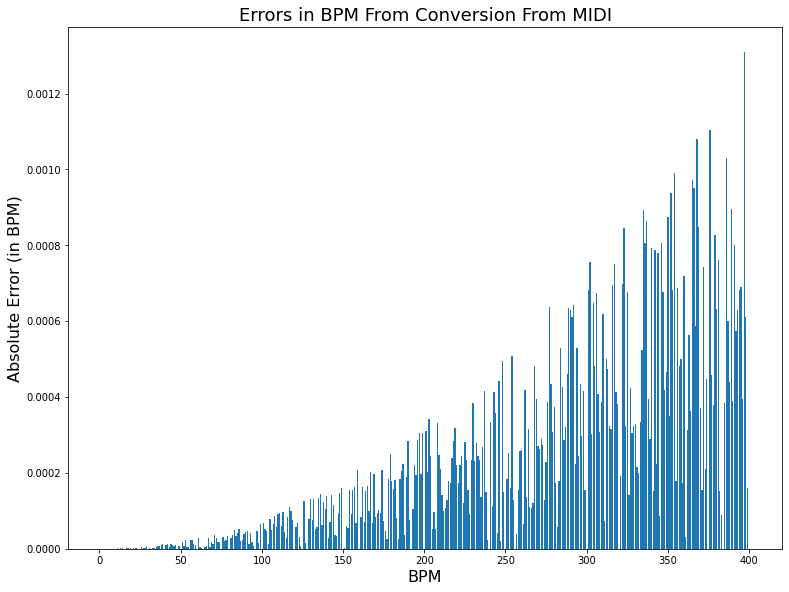

In [8]:
plt.figure(figsize=(12.8, 9.6))
plt.bar(midi_conversion_errors['bpm'], midi_conversion_errors['error'].abs())
plt.title('Errors in BPM From Conversion From MIDI', fontsize=18)
plt.xlabel('BPM', fontsize=16)
plt.ylabel('Absolute Error (in BPM)', fontsize=16)


Unfortunately, it looks like these errors increase as tempo increases, meaning that faster tempos with have larger errors.  It is also worthwile to check the distribution of errors.


Text(0, 0.5, 'Frequency')

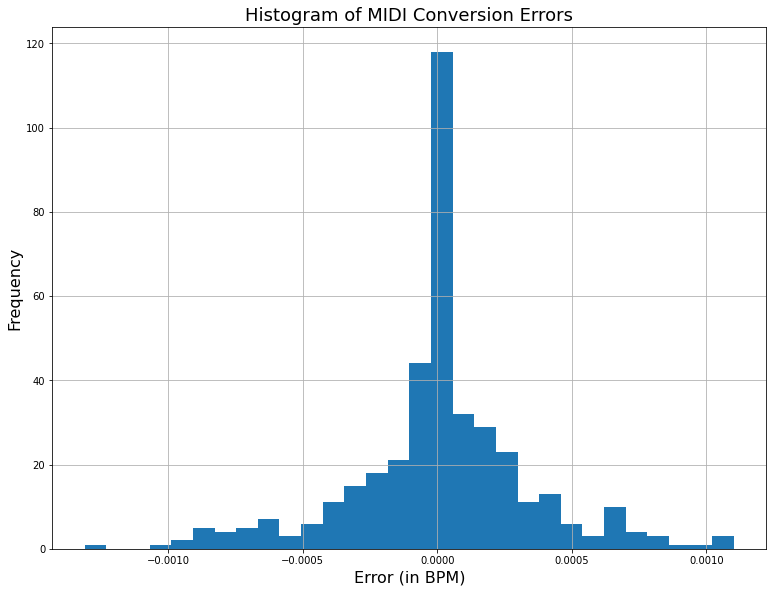

In [9]:
midi_conversion_errors['error'].hist(bins=30, figsize=(12.8, 9.6))
plt.title('Histogram of MIDI Conversion Errors', fontsize=18)
plt.xlabel('Error (in BPM)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

We're lucky in that it looks like most errors are very close to 0, they seem to have a mean of 0, and that extreme errors look much less common.  Good.

## How problematic are these errors?

Given a tempo and a MIDI conversion error for that tempo, after a while of playing, the error will add up enough to be noticable.  We want this error to be attributed to the application, not the player.  After all, the error comes rounding during the manipulation of MIDI files.  Let's visualize how error adds over time with two tempos.

For example, the CSU Fight Song is at 138 bpm.  138 bpm = 434782.60869565216 $\mu\text{spb}$.  Because MIDI only takes integer microseconds per beat, when the MIDI file is created for the tempo, this will be rounded to 434872 $\mu\text{spb}$.  when converted back into bpm, this will yield an errenous tempo of 137.99987580011177 bpm.  Let's model how this error creates problems over time using some theoretical plots.

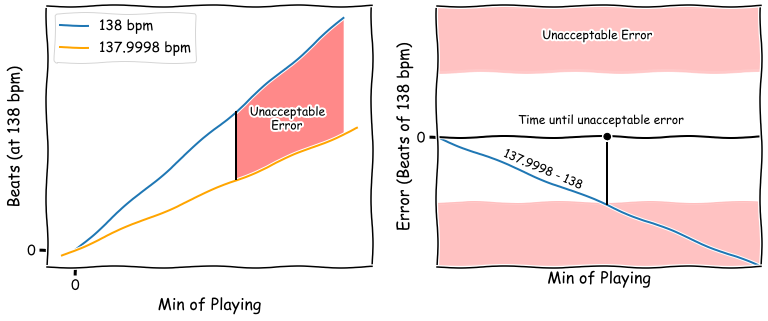

In [10]:
from matplotlib import collections as matcoll

LIGHT_RED = '#ff8989'

def abline(slope, intercept, label='', color=None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    if color is not None:
        return plt.plot(x_vals, y_vals, label=label, c=color)
    else:
        return plt.plot(x_vals, y_vals, label=label)

with plt.xkcd():
    plt.figure(figsize=(12.8, 4.8))

    plt.subplot(1,2,1)
    plt.xticks([0], fontsize=14)
    plt.yticks([0], fontsize=14)
    plt.xlabel('Min of Playing', fontsize=16)
    plt.ylabel('Beats (at 138 bpm)', fontsize=16)
    abline(2,0, '138 bpm')
    abline(1, 0, '137.9998 bpm', 'orange')
    line_x = 0.6
    error_line = matcoll.LineCollection([[(line_x, line_x), (line_x, 2*line_x)]], colors='k')
    plt.gca().add_collection(error_line)
    plt.fill_between(np.linspace(line_x,1,20), np.linspace(line_x,1,20), 2*np.linspace(line_x,1,20), facecolor=LIGHT_RED)
    #plt.fill_between(np.linspace(0,line_x,20), np.linspace(0,line_x,20), 2*np.linspace(0,line_x,20), facecolor='grey')
    plt.annotate('Unacceptable\n      Error', xy=[0.65, 1.6*0.65], fontsize=12)
    plt.legend()

    plt.subplot(1,2,2)
    plt.xticks([])
    plt.yticks([0], fontsize=14)
    plt.xlabel('Min of Playing', fontsize=16)
    plt.ylabel('Error (Beats of 138 bpm)', fontsize=16)
    plt.ylim([-1,1])
    plt.xlim([0, 2])
    abline(-0.5, 0)
    plt.axhline(0, color='black')
    plt.annotate('Unacceptable\n      Error', xy=[0.65, 1.6*0.65], fontsize=12)
    plt.axvspan(-2, 3, 0.75, 1, alpha=0.3, color=LIGHT_RED)
    plt.axvspan(-2, 3, 0, 0.25, alpha=0.3, color=LIGHT_RED)
    plt.annotate('Unacceptable Error', xy=[0.65, 0.75], fontsize=12)
    plt.annotate('137.9998 - 138', xy=[0.4, -0.4], rotation=-23, fontsize=12)
    line_x = 1.05
    error_line = matcoll.LineCollection([[(line_x, 0), (line_x, -0.5*line_x)]], colors='k')
    plt.gca().add_collection(error_line)
    plt.plot([line_x], [0], 'o', color='black')
    plt.annotate('Time until unacceptable error', xy=[0.5, 0.1], fontsize=12)

    


The two plots presented above describe how the error grows linearly over time.  We know this is a linear relationship because there is a **constant difference** in the tempos, which via calculus, means that error grows linearly.  We can imagine that we have some tolerance for error due to rounding, maybe 1ms.  Any error will eventually reach our tolerance level, at which time errors due to MIDI conversion could be falsely attributed to the player.  The solution is to see how long it takes to reach the tolerance, and only bother informing the user if they plan on playing longer than the time needed to reach the tolerance level.

The function below calculates the time in minutes it takes until a converted tempo is off from the original tempo by a specified tolerance.  Below is an example calculation for our 138 bpm example.

In [11]:
def time_until_tolerance_min(bpm, tolerance_ms):

    erronous_tempo = 60000000 / round(60000000 / bpm)
    error = erronous_tempo - bpm
    if error == 0:
        return None

    tolerance_beats = (tolerance_ms * bpm) / (uc.MILLISECONDS_PER_SECOND * uc.SECONDS_PER_MINUTE)

    time_until_tolerance_min = tolerance_beats / abs(error)
    return time_until_tolerance_min


time_until_tolerance_min(138, 1) # you'd have to play the fight song for 18 min to experience 1 ms of error

18.518535183182262

This means that at 138bpm, which gives an erronous tempo of 137.9998, it takes 18.5 minutes of playing before there is 1ms of error due to rounding in MIDI conversion. 

We can use this function to write in tolerances in our table of tempo conversion errors.  In the table, `time_until_1ms (min)` is the time in minutes until the errornous tempo is off from the correct tempo by 1ms.  The `time_until_5_ms (min)` and `time_until_10_ms (min)` columns have similar interpretations.  When these columns have a value of `nan`, this is because there is 0 conversion error, and the error tolerance will never be reached.

In [12]:
midi_conversion_errors['time_until_1ms (min)'] = midi_conversion_errors['bpm'].apply(lambda bpm: time_until_tolerance_min(bpm, 1))
midi_conversion_errors['time_until_5ms (min)'] = midi_conversion_errors['bpm'].apply(lambda bpm: time_until_tolerance_min(bpm, 5))
midi_conversion_errors['time_until_10ms (min)'] = midi_conversion_errors['bpm'].apply(lambda bpm: time_until_tolerance_min(bpm, 10))

midi_conversion_errors.style.hide_index()

bpm,uspb,rounded uspb,converted_tempo,error,time_until_1ms (min),time_until_5ms (min),time_until_10ms (min)
1,60000000.000000,60000000.000000,1.000000,0.000000,nan,nan,nan
2,30000000.000000,30000000.000000,2.000000,0.000000,nan,nan,nan
3,20000000.000000,20000000.000000,3.000000,0.000000,nan,nan,nan
4,15000000.000000,15000000.000000,4.000000,0.000000,nan,nan,nan
5,12000000.000000,12000000.000000,5.000000,0.000000,nan,nan,nan
6,10000000.000000,10000000.000000,6.000000,0.000000,nan,nan,nan
7,8571428.571429,8571429.000000,7.000000,-0.000000,333.333350,1666.666749,3333.333497
8,7500000.000000,7500000.000000,8.000000,0.000000,nan,nan,nan
9,6666666.666667,6666667.000000,9.000000,-0.000000,333.333350,1666.666752,3333.333505
10,6000000.000000,6000000.000000,10.000000,0.000000,nan,nan,nan


Which of these errors reach our tolerance for error the fastest?  Let's sort by `time_until_1ms (min)` and look at the 5 most problematic tempos.

In [13]:
midi_conversion_errors.sort_values(by='time_until_1ms (min)').head(5).style.hide_index()

bpm,uspb,rounded uspb,converted_tempo,error,time_until_1ms (min),time_until_5ms (min),time_until_10ms (min)
397,151133.501259,151134.000000,396.998690,-0.001310,5.050522,25.252609,50.505217
376,159574.468085,159574.000000,376.001103,0.001103,5.681802,28.409008,56.818015
368,163043.478261,163043.000000,368.001079,0.001079,5.681802,28.409008,56.818015
354,169491.525424,169492.000000,353.999009,-0.000991,5.952398,29.761988,59.523976
335,179104.477612,179104.000000,335.000893,0.000893,6.249983,31.249917,62.499833


Let's also examine the error for common tempos:

In [14]:
common_tempos = [102,120,132,144,156,168,180,192,200]

midi_conversion_errors[midi_conversion_errors['bpm'].isin(common_tempos)].style.hide_index()


bpm,uspb,rounded uspb,converted_tempo,error,time_until_1ms (min),time_until_5ms (min),time_until_10ms (min)
102,588235.294118,588235.000000,102.000051,0.000051,33.333317,166.666583,333.333167
120,500000.000000,500000.000000,120.000000,0.000000,nan,nan,nan
132,454545.454545,454545.000000,132.000132,0.000132,16.666650,83.333250,166.666500
144,416666.666667,416667.000000,143.999885,-0.000115,20.833350,104.166750,208.333500
156,384615.384615,384615.000000,156.000156,0.000156,16.666650,83.333250,166.666500
168,357142.857143,357143.000000,167.999933,-0.000067,41.666683,208.333417,416.666833
180,333333.333333,333333.000000,180.000180,0.000180,16.666650,83.333250,166.666500
192,312500.000000,312500.000000,192.000000,0.000000,nan,nan,nan
200,300000.000000,300000.000000,200.000000,0.000000,nan,nan,nan


The most problematic of all these errors is at 397 beats per minute, when 5.05 minutes of playing will put you off from the original tempo by more that 1ms.  All other errors will require the player to play longer than 5.05 minutes for more than 1ms of error.  This would be a very lengthy piece for the player to be playing at that tempo, which suggests that the error is not worth considering.  Another reason to ignore this error is the fact that it takes 5.05 minutes to reach 1ms of error, which is an extremely conservative tolerance for error.  

### Another approach

Rounding is strongest when a number is in the middle of two integers, when it has a decimal of $.5$.  We can use this fact to determine the largest error possible.  From our analysis above, we know that faster tempos have larger errors, so we will use our maximum tempo to calculate the tempo with the largest error.  See below for the calculation.

In [15]:
max_tempo_uspb = bpm_to_usbp(max_tempo)
print(max_tempo_uspb)

max_erroneous_uspb = max_tempo_uspb - 0.5
print(max_erroneous_uspb)

max_erroneous_tempo = uspb_to_bpm(max_erroneous_uspb)
print(max_erroneous_tempo)

max_error = abs(max_tempo - max_erroneous_tempo)
print(max_error)

print(time_until_tolerance_min(max_erroneous_tempo, 1))

150000.0
149999.5
400.0013333377778
0.0013333377777939859
4.999999999994776


The calculation above suggests that using our maximum tempo, our maximum error is 0.00133 bpm.  At our maximum tempo, this error becomes problematic after 5 minutes, yielding an error of 1ms.  

Together, the numerical analysis and direct approach show that the error can safely be ignored.  At any tempo, the time it takes to reach an error of 1ms (which is a very conservative margin) is over 5 minutes, which is sometimes longer than pieces of music somebody might play. 

Now that we have a maximum error, we can assume that if a number is within 0.00133 of an integer, that it probably is an integer tempo, and we can just round it.

# Computing MIDI

In [16]:
midi_vector = mp.get_midi_vector(mid)
midi_vector

array([ 0.        ,  0.2173915 ,  0.32608725,  0.434783  ,  0.6521745 ,
        0.76087025,  0.869566  ,  1.0869575 ,  1.304349  ,  1.41304475,
        1.5217405 ,  1.63043625,  1.739132  ,  1.9565235 ,  2.06521925,
        2.173915  ,  2.3913065 ,  2.50000225,  2.608698  ,  2.8260895 ,
        2.93478525,  3.043481  ,  3.15217675,  3.2608725 ,  3.36956825,
        3.478264  ,  3.6956555 ,  3.913047  ,  4.05797467,  4.20290233,
        4.34783   ,  4.5652215 ,  4.782613  ,  4.92754067,  5.07246833,
        5.217396  ,  5.28985983,  5.36232367,  5.4347875 ,  5.50725133,
        5.57971517,  5.652179  ,  5.72464283,  5.79710667,  5.8695705 ,
        5.94203433,  6.01449817,  6.086962  ,  6.956528  ,  7.1739195 ,
        7.28261525,  7.391311  ,  7.6087025 ,  7.71739825,  7.826094  ,
        8.0434855 ,  8.260877  ,  8.36957275,  8.4782685 ,  8.58696425,
        8.69566   ,  8.9130515 ,  9.02174725,  9.130443  ,  9.3478345 ,
        9.45653025,  9.565226  ,  9.7826175 ,  9.89131325, 10.00

# Plotting MIDI

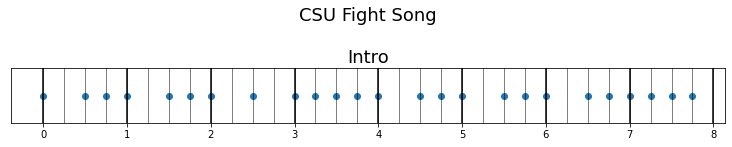

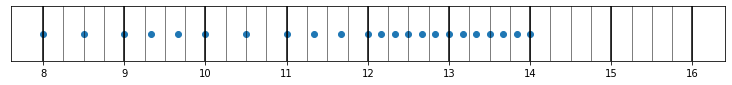

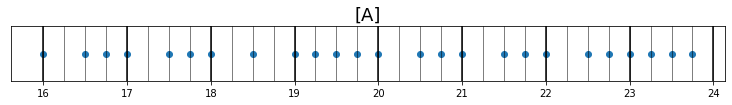

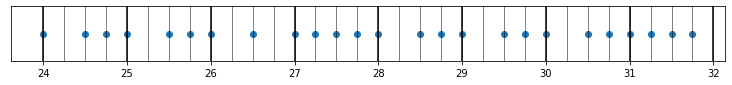

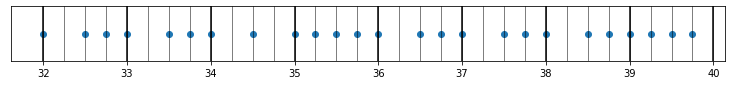

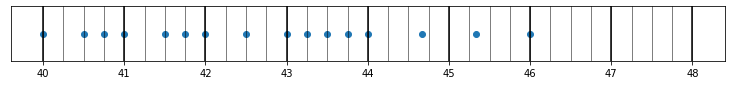

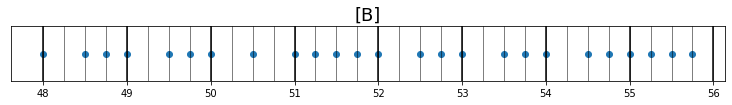

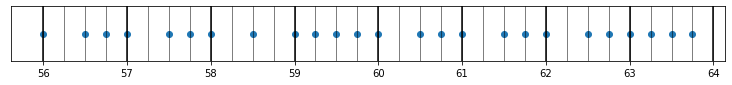

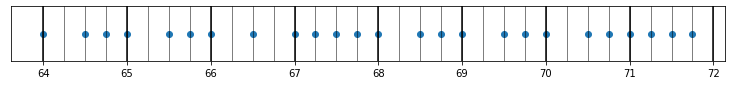

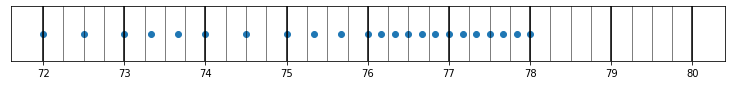

In [17]:
# Plot the first half of the fight song, four measures at a time
meter = 2 # 2/4 time
measures = 40
measures_per_line = 4

for start_beat in range(0, meter*measures, meter*measures_per_line):
    if start_beat == 0:
        title = 'CSU Fight Song\n\nIntro'
    elif start_beat == 16:
        title = '[A]'
    elif start_beat == 48:
        title = '[B]'
    else:
        title = ''

    nbt.plot_midi_vector(midi_vector, 138, time_range=(start_beat, start_beat+8), 
                         subdivisions_per_beat=4, x_label='', title=title)

# Floating Point Errors on MIDI Vector

The timestamps stored in the MIDI vector $\overrightarrow m$ are stored as Python `float`s.  Python stores their `float` type as a double precision, or the IEEE-754 format [[Section 15.1 - Representation Error]](https://docs.python.org/3/tutorial/floatingpoint.html).

The MIDI vector is calculated by creating a cummulative sum of the duration of each note in seconds.  Because each duration is stored as a `float` and floating point error exists, it's possible that we accumulate error along elements in the vector.  This error can theoretically create problems.

For the same reasons as the numerical analysis performed in the **MIDI Conversion Rounding Error** section, these errors can be ignored.  Floating point errors are larger for larger numbers, but for most durations, which are less than a second, the errors are *extremely* small (on the order of $2^{-52}$).  Even accumulated over a large number of notes, these errors aren't very problematic.  Undoccumented work on this project showed that you'd have to play extremely fast (faster than humans can) for a very long time for there to be 1ms of error.  To view the order of precision on these times, just see the time attributes on the messages list below.


In [18]:
[message for message in mid][0:20]

[MetaMessage('track_name', name='Snare Drum\x00', time=0),
 MetaMessage('time_signature', numerator=2, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
 MetaMessage('key_signature', key='C', time=0),
 MetaMessage('set_tempo', tempo=434783, time=0),
 Message('control_change', channel=9, control=121, value=0, time=0),
 Message('program_change', channel=9, program=56, time=0),
 Message('control_change', channel=9, control=7, value=100, time=0),
 Message('control_change', channel=9, control=10, value=64, time=0),
 Message('control_change', channel=9, control=91, value=0, time=0),
 Message('control_change', channel=9, control=93, value=0, time=0),
 MetaMessage('midi_port', port=0, time=0),
 Message('note_on', channel=9, note=50, velocity=124, time=0),
 Message('note_on', channel=9, note=50, velocity=0, time=0.21648570208333331),
 Message('note_on', channel=9, note=50, velocity=96, time=0.0009057979166666666),
 Message('note_on', channel=9, note=50, velocity=0, tim

In conclusion, these errors can also be ignored.  See these links for more info on the subject:

* [Mido Documentation - Under "The Time Attribute"](https://mido.readthedocs.io/en/latest/messages.html)
* [Mido Documentation - Under "Iterating Over Messages"](https://mido.readthedocs.io/en/latest/midi_files.html)
* [Wikipeda - Double-precision floating-point format](https://en.wikipedia.org/wiki/Double-precision_floating-point_format)
* [Python Documentation - Floating Point Arithmetic: Issues and Limitations](https://docs.python.org/3/tutorial/floatingpoint.html)